# Momento de Retroalimentación: Módulo 5 Preprocesamiento de datos multivariados o de una serie temporal (Portafolio Implementación).

## Cargando los datos.

Importamos las librerías necesarias.

In [ ]:
!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tbats import TBATS

Cargamos los datos de alcohol sales

In [ ]:
df = pd.read_csv('Alcohol_Sales.csv')
df.columns = ['date', 'sales']
df['date'] = df['date'].astype('str')
df

,date,sales
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


Verificamos que no haya información faltante

In [ ]:
print("Valores NaN: \n" + str(df.isna().sum()))
print()
print("Valores nulos: \n" + str(df.isnull().sum()))

Valores NaN: 
date     0
sales    0
dtype: int64

Valores nulos: 
date     0
sales    0
dtype: int64


La serie de tiempo no tiene valores nan ni valores nulos.

## Estacionalidad de los datos.

In [ ]:
# Partimos los datos en entrenamiento y test
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

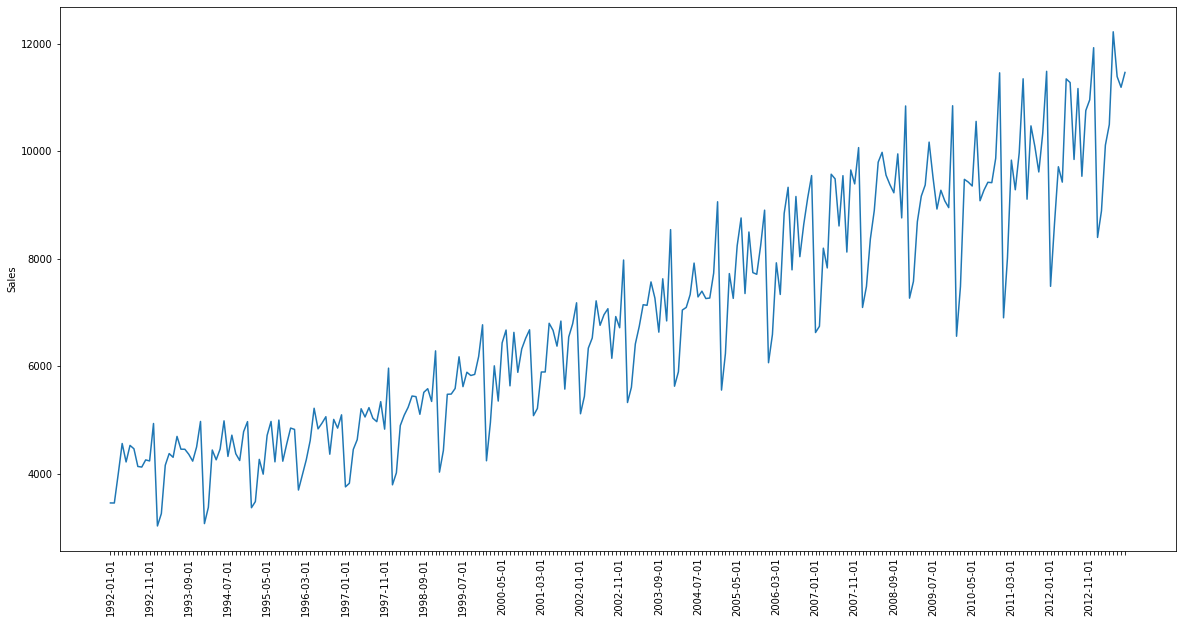

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(df_train['date'], df_train['sales'])
plt.xticks(rotation = 90,size=10)
plt.ylabel('Sales')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.show()

La serie de tiempo no parece tener outliers ni parece estacionaria. Esto lo podemos comprobar haciendo las pruebas de Dickey-Fuller y KPSS.

In [ ]:
# Función que realiza los tests
def test_stationary(timeseries):
	#Determining rolling statistics
	rolmean = timeseries.rolling(window=12).mean()
	rolstd = timeseries.rolling(window=12).std()
	
	#Plotting rolling statistics
	orig = plt.plot(timeseries, color='blue', label='Original')
	mean = plt.plot(rolmean, color='red', label='Rolling Mean')
	st = plt.plot(rolstd, color='black', label='Rolling Std')
	plt.legend(loc='best')
	plt.title('Rolling Mean & Standard Deviation')
	plt.rcParams["figure.figsize"] = (30,10)
	plt.show()
	print()
	#Dickey-Fuller test:
	print('Results of Dickey-Fuller Test:')
	dftest = adfuller(timeseries)
	dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
	for key, value in dftest[4].items():
		dfoutput['Critical Value(%s)' %key] = value
	print(dfoutput)
	print()
	#KPSS test:
	print('Results of KPSS Test:')
	kpsstest = kpss(timeseries, regression='c')
	kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', '#Lags Used'])
	for key, value in kpsstest[3].items():
		kpss_output['Critical Value (%s)' %key] = value
	print(kpss_output)

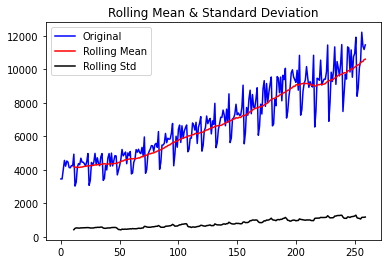


Results of Dickey-Fuller Test:
Test Statistic                   1.534774
p-value                          0.997648
#Lags Used                      14.000000
Number of Observations Used    245.000000
Critical Value(1%)              -3.457326
Critical Value(5%)              -2.873410
Critical Value(10%)             -2.573096
dtype: float64

Results of KPSS Test:
Test Statistic            2.468021
p-value                   0.010000
#Lags Used               10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [ ]:
test_stationary(df_train['sales'])

El test de Dickey-Fuller nos dice que el $\text{p-value}>0.05$ y el test KPSS nos dice que  $\text{p-value}<0.05$ , por lo tanto, podemos concluir que la serie no es estacionaria. También podemos apreciar que la serie tiene una tendencia que debemos eliminar para convertirla en estacionaria.


## Haciendo una diferenciación

Para que la serie se convierta en estacionaria, es necesario hacier una diferenciación.

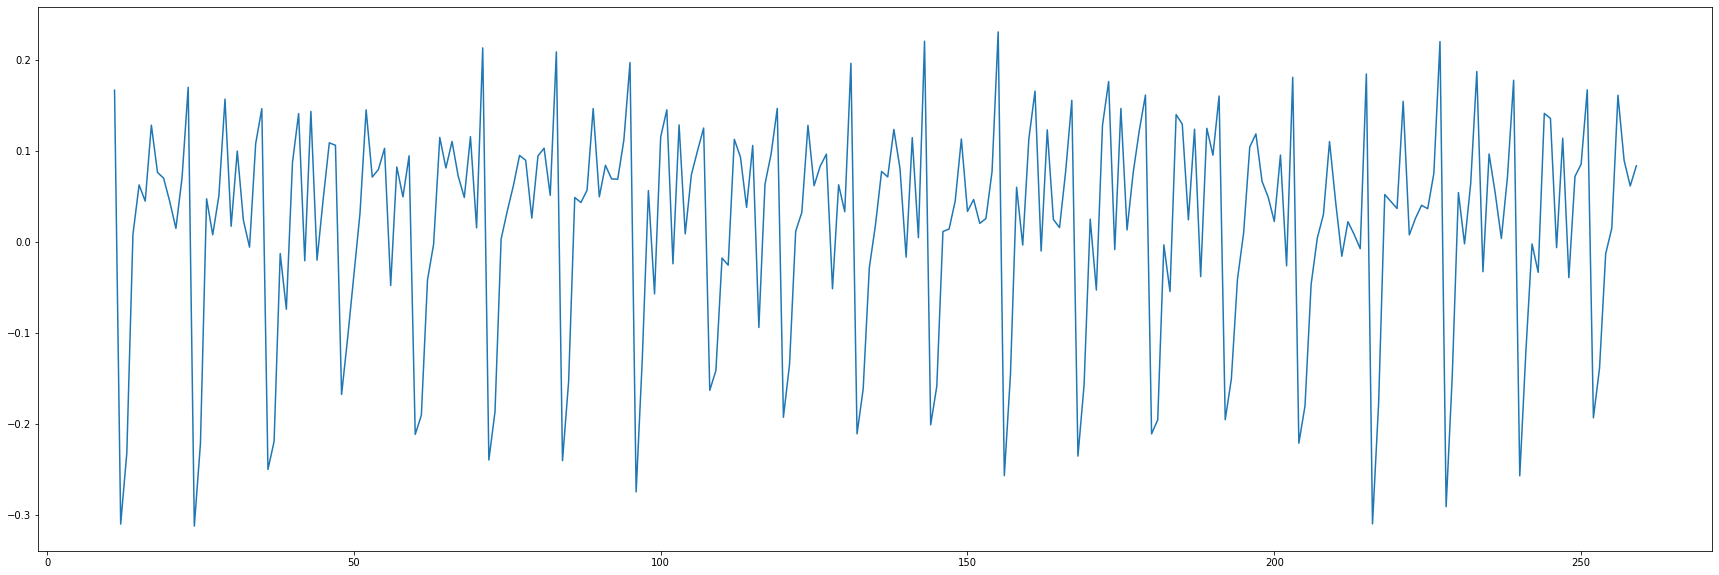

In [ ]:
tslog = np.log(df_train['sales'])
rollavg = tslog.rolling(12).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

La serie se ve más estacionaria, pero aún se debe confirmar con los tests Dickey-Fuller y KPSS.

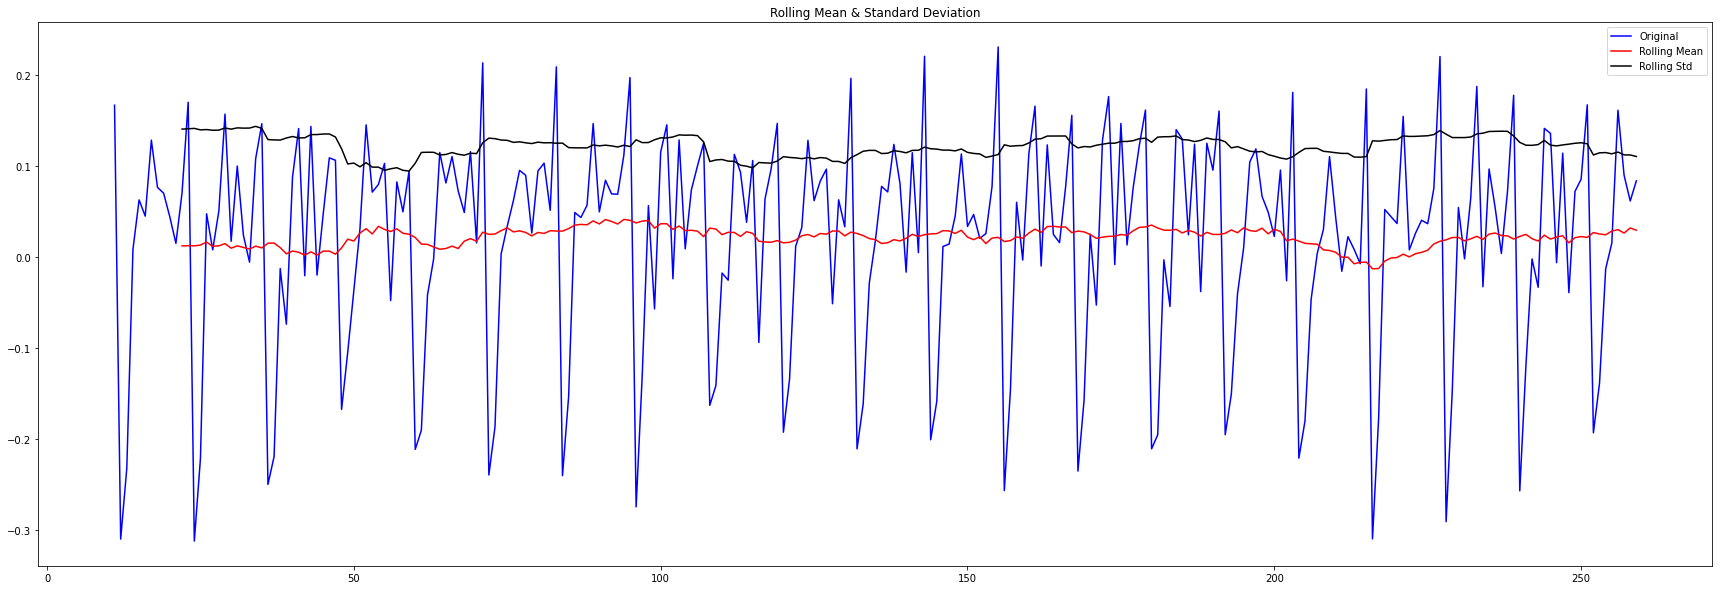


Results of Dickey-Fuller Test:
Test Statistic                  -3.531175
p-value                          0.007222
#Lags Used                      14.000000
Number of Observations Used    234.000000
Critical Value(1%)              -3.458608
Critical Value(5%)              -2.873972
Critical Value(10%)             -2.573396
dtype: float64

Results of KPSS Test:
Test Statistic           0.039888
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
test_stationary(tslogdiff)

Ambos tests nos indican que la serie es estacionaria ya que:

Dickey-Fuller: $\text{p-value}<0.05$ y

KPSS: $\text{p-value}>0.05$. 

También podemos apreciar que la tendencia se ha reducido y la desviación de los datos es muy pequeña.

## ACF y PACF.

Para poder analizar el ACF y el PACF de la serie se requiere hacer otra transformación. Usaremos el logaritmo para estabilizar la variancia y aplicar la diferenciación basado en $t-1$ usando $r_t=log(\frac{X_t}{X_{t-1}})$

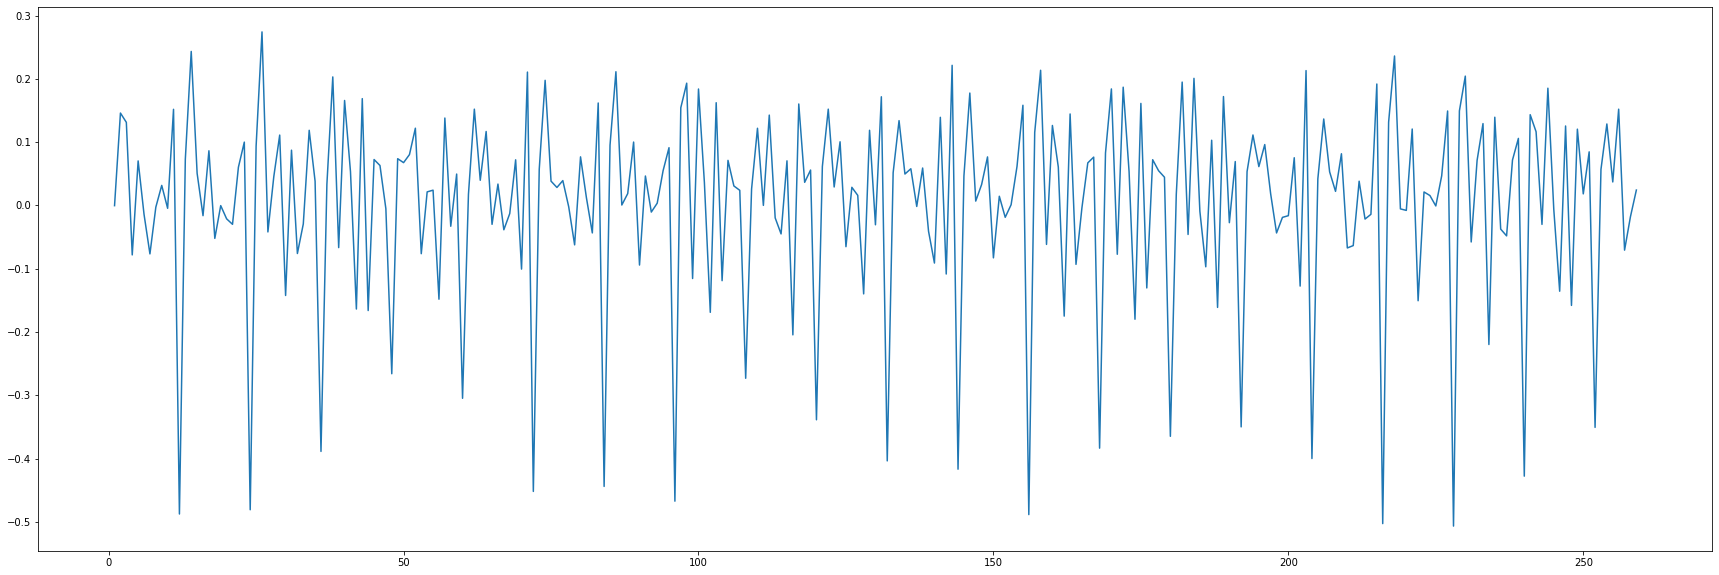

In [ ]:
tslog = np.log(df_train['sales'])
logret= diff(tslog)
plt.plot(logret)
plt.show()

Procedemos a graficar el ACF y el PACF para ver las autocorrelaciones de las series.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


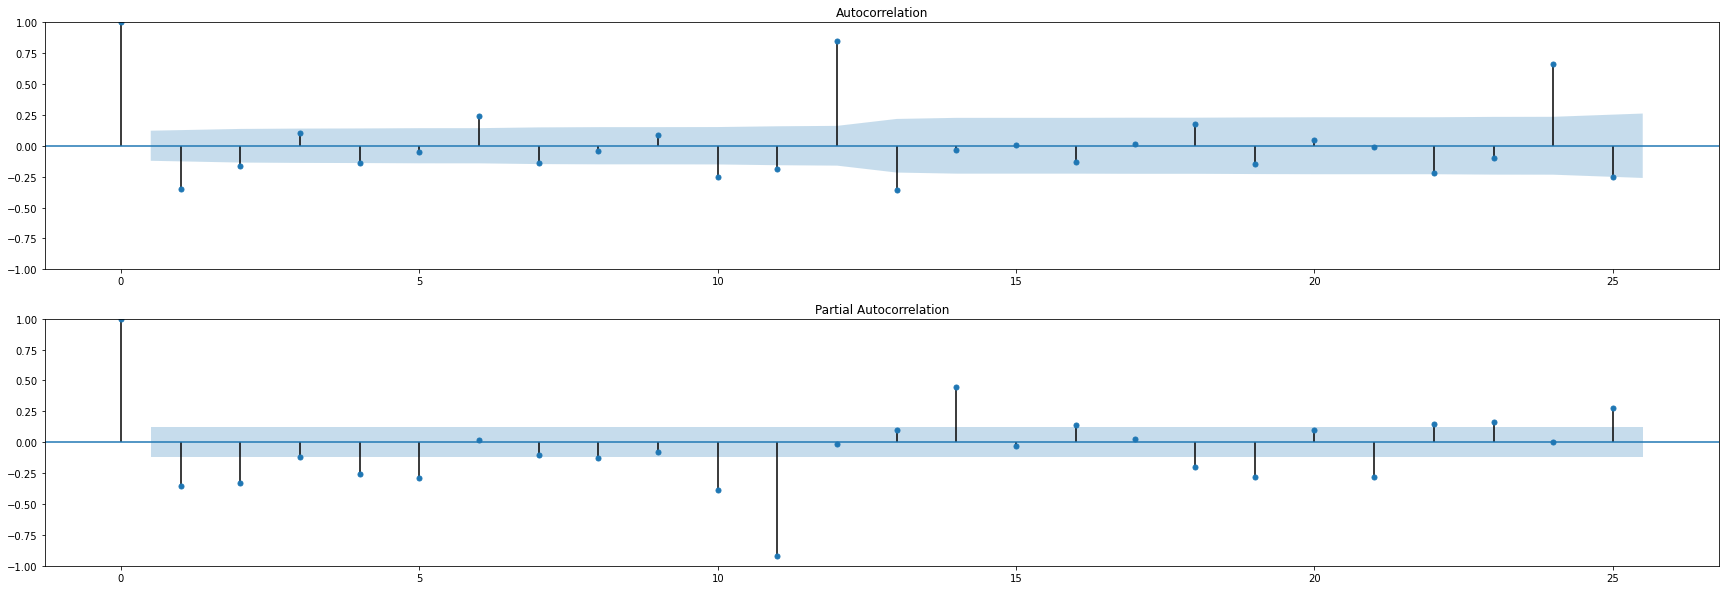

In [ ]:
fig, ax = plt.subplots(2, 1)
plot_acf(logret, ax=ax[0])
plot_pacf(logret, ax=ax[1])
plt.show()

Podemos ver que los valores en 1, 12 y 24 son bastante significativos. Aplicaremos otra diferenciación tomando una estacionalidad de 12 ya que cada valor de correlación ocurre mas frecuentemente en múltiplos de 12.

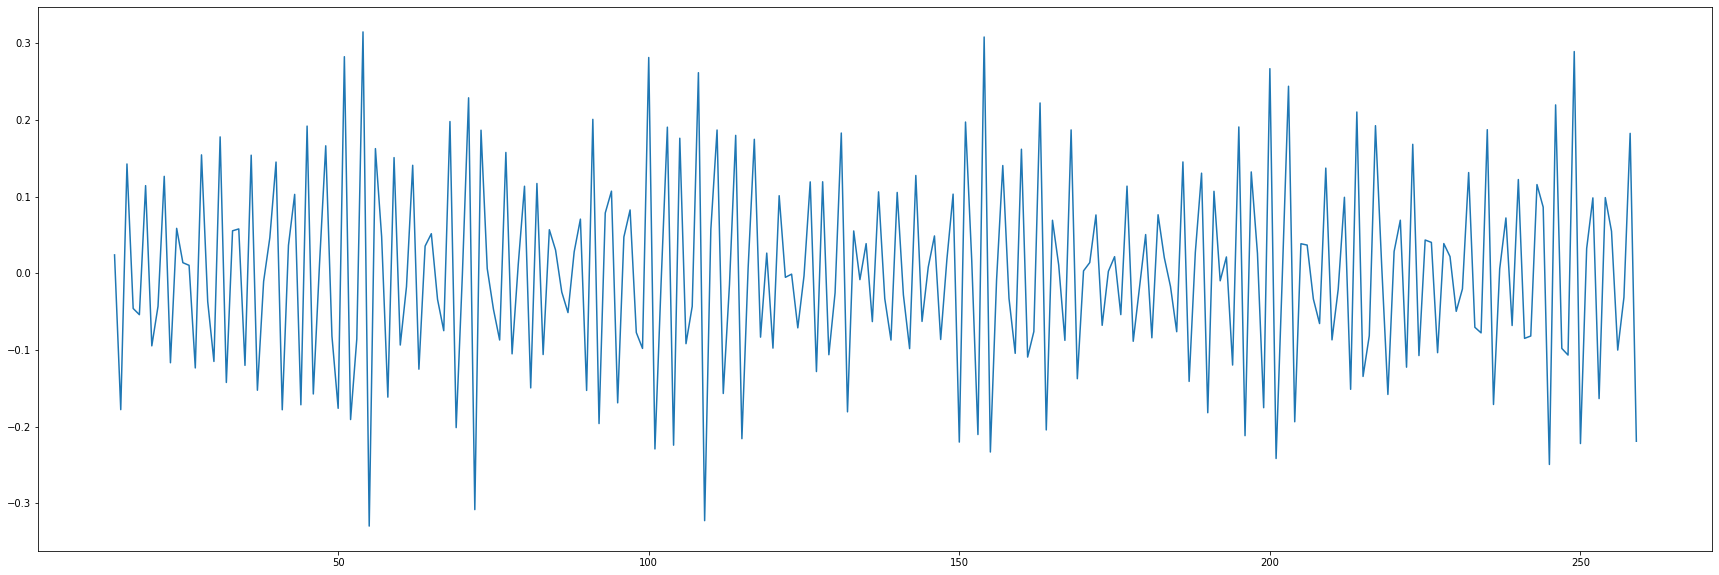

In [ ]:
slogret= diff(diff(tslog), k_seasonal_diff=1, seasonal_periods=12)
plt.plot(slogret)
plt.show()

Ahora vamos a aplicar el test de Ljung-Box para verificar si la autocorrelación se redujo.

In [ ]:
m = int(np.log(df.shape[0]))
acorr_ljungbox(slogret, lags=[m])

,lb_stat,lb_pvalue
5,229.421672,1.422833e-47


El valor del $\text{p-value}$ es menor que $0.05$, y así sabemos que aún hay correlación entre los datos. A continuación, vamos a volver a plotear ACF y PACF para confirmarlo.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


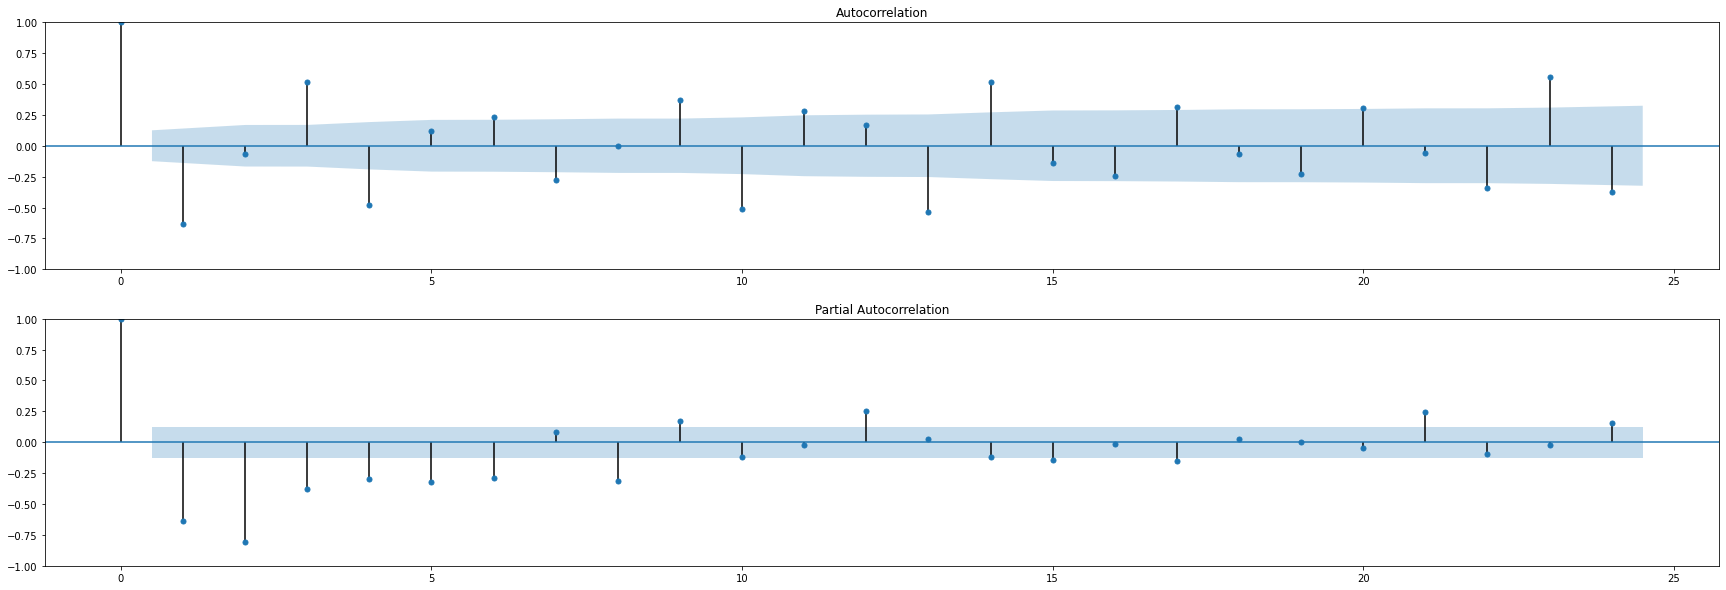

In [ ]:
fig, ax = plt.subplots(2, 1)
plot_acf(slogret, ax=ax[0])
plot_pacf(slogret, ax=ax[1])
plt.show()

 Como podemos ver aún hay autocorrelación. Así que haremos otra diferenciación

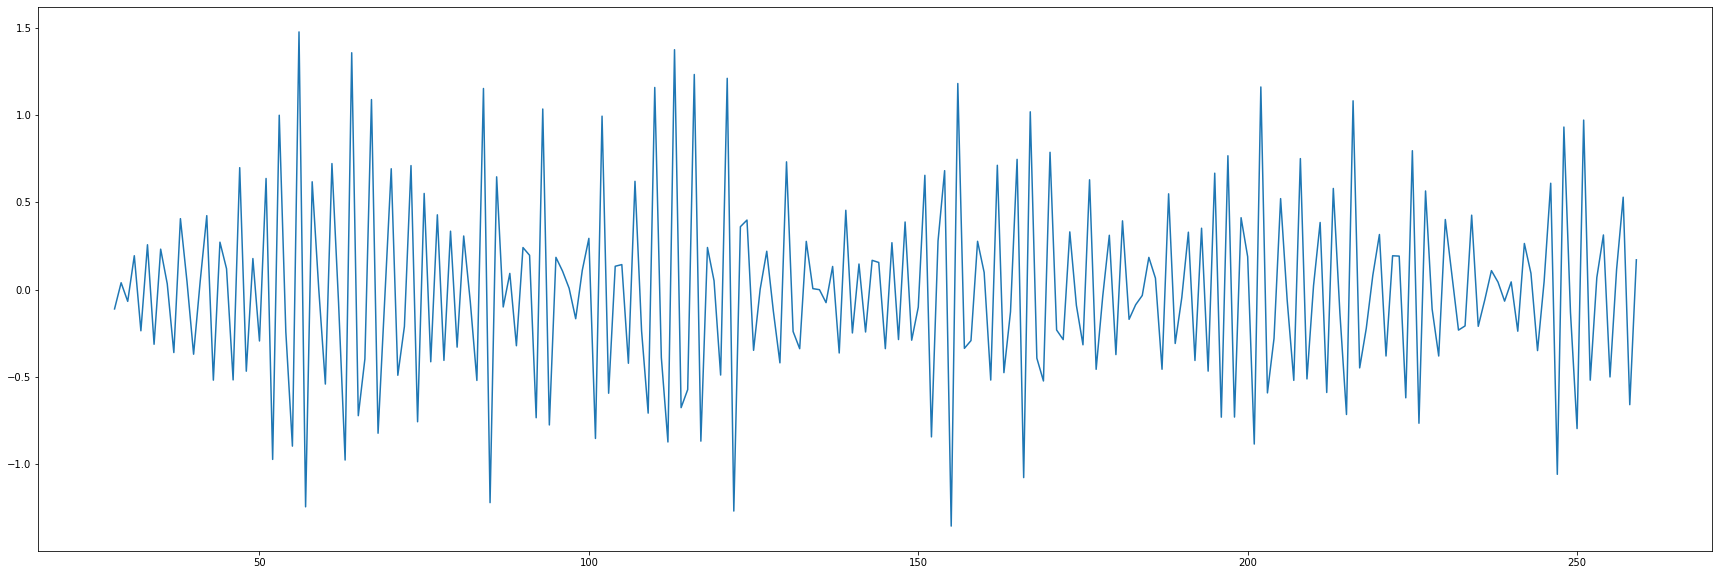

In [ ]:
slogret= diff(diff(slogret), k_seasonal_diff=1, seasonal_periods=12)
plt.plot(slogret)
plt.show()

Ahora vamos a aplicar el test de Ljung-Box para verificar si la autocorrelación se redujo.

In [ ]:
m = int(np.log(df.shape[0]))
acorr_ljungbox(slogret, lags=[m])

,lb_stat,lb_pvalue
5,208.052897,5.372964e-43


Como podemos ver, la autocorrelación aún existe ya que el $\text{p-value}$ es menor a 0.05 todavía, pero no podemos hacer otra diferenciación sin afectar significativamente los datos. Así que vamos a plotear nuevamente PACF y ACF.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


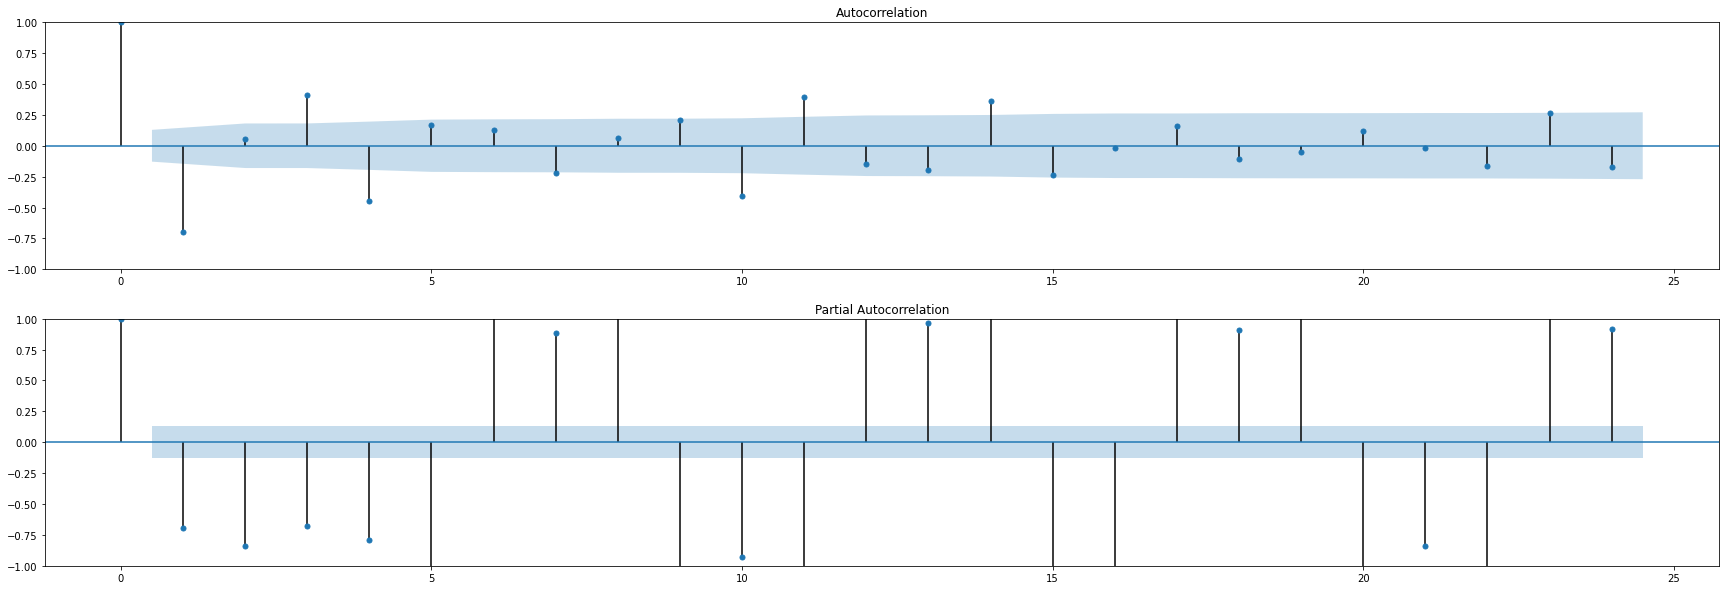

In [ ]:
fig, ax = plt.subplots(2, 1)
plot_acf(slogret, ax=ax[0])
plot_pacf(slogret, ax=ax[1])
plt.show()

Las gráficas de PACF y ACF (descartando los valores residuales) nos dicen que procesos MA y AR de orden 1 ($p=1$) son necesarios

>$q=0,1$,$Q=0,1$

>$p=0,1$,$P=0,1$

>$d=2$,$D=2$

In [ ]:
pp = []
qq = []
PP = []
QQ = []
aic = []
lb = []
sse = []
for p in range(0,2):
    for q in range(0,2):
        for P in range(0,2):
            for Q in range(0,2):
                model=sm.tsa.statespace.SARIMAX(np.log(df_train['sales']),order=(p, 2, q),seasonal_order=(P,2,Q,12))
                res = model.fit()
                pp.append(p)
                qq.append(q)
                PP.append(P)
                QQ.append(Q)
                aic.append(res.aic)
                lb.append(acorr_ljungbox(res.resid, lags=[m]))
                sse.append((res.resid**2).sum())
            
resdf = pd.DataFrame()
resdf['p']=pp
resdf['q']=qq
resdf['PP']=PP
resdf['QQ']=QQ
resdf['AIC']=aic
resdf['lb-p-value']=lb
resdf['sse']=sse

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
resdf.sort_values('AIC', ascending = True)

,p,q,PP,QQ,AIC,lb-p-value,sse
15,1,1,1,1,-581.296235,lb_stat lb_pvalue 5 65.140488 1.048...,164.497742
13,1,1,0,1,-579.234532,lb_stat lb_pvalue 5 65.165584 1.035...,164.518493
14,1,1,1,0,-502.206828,lb_stat lb_pvalue 5 65.037018 1.101...,164.928361
7,0,1,1,1,-497.543234,lb_stat lb_pvalue 5 65.556548 8.590...,164.982580
12,1,1,0,0,-490.210600,lb_stat lb_pvalue 5 64.927703 1.160...,165.024122
5,0,1,0,1,-490.004820,lb_stat lb_pvalue 5 65.613349 8.360...,165.046249
6,0,1,1,0,-423.760429,lb_stat lb_pvalue 5 65.600632 8.411...,165.563807
4,0,1,0,0,-418.390600,lb_stat lb_pvalue 5 65.545469 8.636...,165.634964
11,1,0,1,1,-360.241475,lb_stat lb_pvalue 5 65.545756 8.635...,166.233249
9,1,0,0,1,-355.041978,lb_stat lb_pvalue 5 65.637497 8.264...,166.311586


Para escoger el mejor modelo es necesario tomar en consideracion lo siguiente:

*   El valor más bajo de AIC.
*   El menor valor de SSE.

Estos valores indican que hay una baja correlación en los residuales. En este caso en particular, los modelos 15, 13 y 14 son los mejores. 
Tomando en cuenta que siempre debemos apuntar a un modelo más simple, descartaremos automáticamente el modelo 15 y tomaremos el modelo 7.

Este modelo SARIMA es $SARIMA(1, 2, 1, 0, 2, 1)_12$



In [ ]:
model=sm.tsa.statespace.SARIMAX(np.log(df_train['sales']),order=(1, 2, 1),seasonal_order=(0, 2, 1, 12))
res = model.fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  260
Model:             SARIMAX(1, 2, 1)x(0, 2, 1, 12)   Log Likelihood                 293.617
Date:                            Wed, 30 Nov 2022   AIC                           -579.235
Time:                                    03:39:50   BIC                           -565.413
Sample:                                         0   HQIC                          -573.662
                                            - 260                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5748      0.057    -10.114      0.000      -0.686      -0.463
ma.L1         -0.9817      0.127     -7.745      0.000      -1.230      -0.733
ma.S.L12      -0.9966      3.329     -0.299      0.765      -7.521       5.528
sigma2         0.0040      0.013      0.304      0.761      -0.022       0.030
===================================================================================
Ljung-Box (L1) (Q):                  37.87   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               0.87   Skew:                            -0.08
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Como podemos ver, nuestro valor de nuestra prueba de Prob(JB) es mucho mayor a 0.05. Así que este modelo explica gran cantidad de los datos. Vamos a realizar una predicción para evaluar el modelo

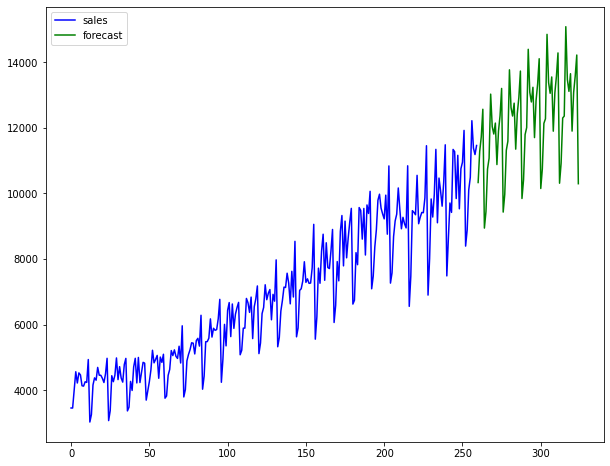

In [ ]:
forecast=np.exp(res.predict(start=260,end=324,signal_only=True,dynamic=True))

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(df_train.index,df_train['sales'],label='sales',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

Parece que el modelo trabaja bien, pero aún debemos confirmar qué tan preciso es con respecto a los valores reales con valores que no ha visto.

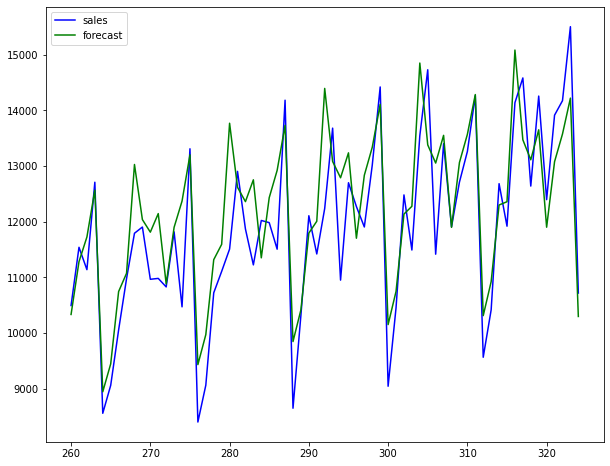

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(df_test.index,df_test['sales'],label='sales',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

Como podemos ver, el modelo predice bien. Vamos a evaluarlo.
# Evaluación del modelo y su aplicación para predicción
Podemos utilizar el modelo TBATS de 12 periodos ya que son los periodos que estamos usando y la periodicidad de 6, que es la segunda más frecuente, para poder calcular los mean absolute square errors para ver que modelo tiene un mejor desempeño.


In [ ]:
tbats_est = TBATS(seasonal_periods=(12,6))
tbats_mod = tbats_est.fit(df_train['sales'])

In [ ]:
forecast_2 = tbats_mod.forecast(steps=65)
forecast_2 = pd.DataFrame(forecast_2, index=[i for i in range(260, 325)])
forecast_2

,0
260,11391.868258
261,11354.234765
262,11932.969196
263,11759.579358
264,9519.153613
...,...
320,16670.422511
321,15798.999512
322,16732.226013
323,16489.651720


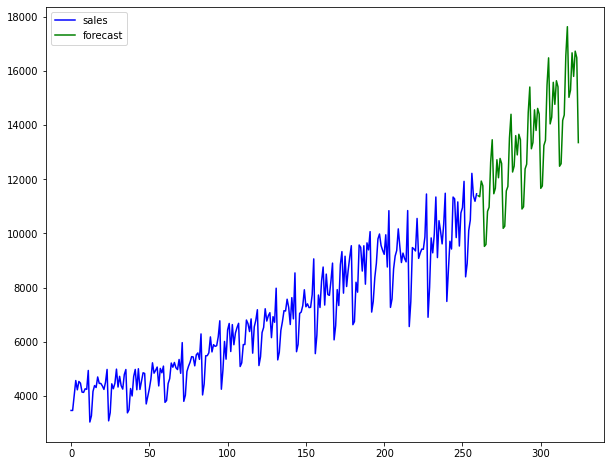

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(df_train.index,df_train['sales'],label='sales',color='blue')
ax.plot(forecast_2,label='forecast',color='green')
plt.legend()
plt.show()

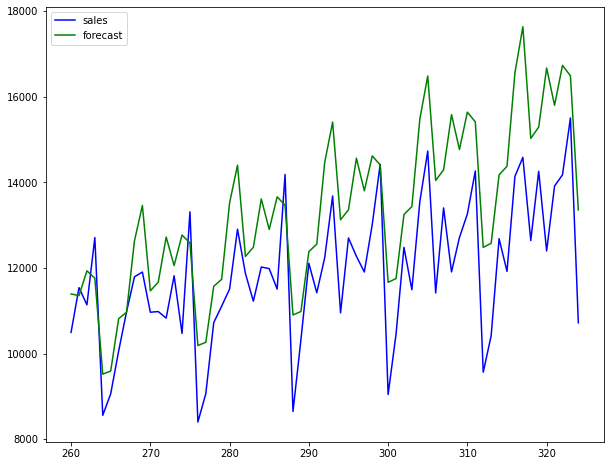

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(df_test.index,df_test['sales'],label='sales',color='blue')
ax.plot(forecast_2,label='forecast',color='green')
plt.legend()
plt.show()

In [ ]:
mae_sarima = mean_absolute_error(df_test['sales'], forecast)
mae_tbats = mean_absolute_error(df_test['sales'], forecast_2)
print('MAE SARIMA: ', mae_sarima)
print('MAE TBATS: ', mae_tbats)

MAE SARIMA:  688.8738977613796
MAE TBATS:  1524.5632806001636


Como podemos ver, el error de SARIMA es muchisimo menor que el que realizamos con TBATS. Debido a esto, podemos concluir que el modelo SARIMA elegido es una buena opción ya que el MAE es significativamente pequeño, además de que no tenemos un modelo tan complejo debido a que tenemos pocos parámetros.